# Paper CHF - 64 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_64beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,267.535629,270.981533,270.243834,76.791207,11.207306,0.483334,-0.435149,-0.637676,-0.096703,...,-0.047331,0.034527,-0.042788,0.048729,-0.072291,0.006842,-0.025811,-0.008343,-0.007415,NSR
1,e0106,277.949875,283.546637,283.543383,80.370321,11.621628,0.480582,-0.437337,-0.666380,-0.138188,...,-0.053865,0.034099,-0.034026,0.038144,-0.071427,0.011442,-0.027634,-0.009450,-0.002719,NSR
2,e0106,280.952321,289.729213,288.768479,81.676148,11.842770,0.479468,-0.434101,-0.641674,-0.075015,...,-0.041838,0.031072,-0.035728,0.040951,-0.067828,0.007170,-0.022649,-0.013308,-0.001871,NSR
3,e0106,266.093352,277.366979,279.066959,79.365536,11.515873,0.479998,-0.433339,-0.648197,-0.093792,...,-0.047719,0.029625,-0.035988,0.049478,-0.081219,0.019213,-0.029185,-0.014198,-0.000186,NSR
4,e0106,279.838160,290.933842,289.849559,81.839924,11.791220,0.479852,-0.432266,-0.660649,-0.107788,...,-0.050448,0.030725,-0.035125,0.042994,-0.070263,0.010677,-0.027446,-0.011952,-0.001447,NSR


In [5]:
data['label'].value_counts()

NSR    6531
ST-    1377
ST+     613
Name: label, dtype: int64

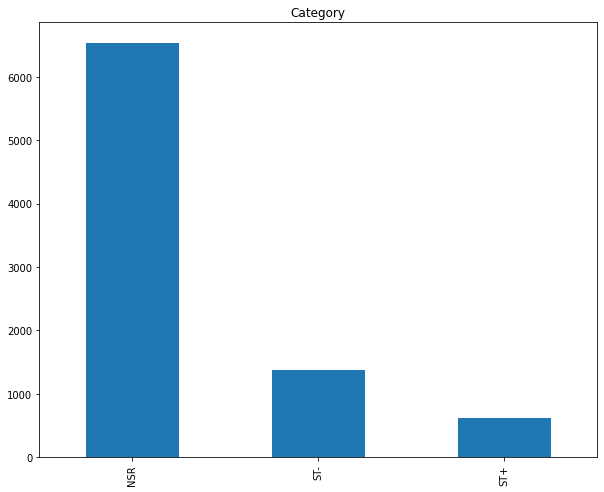

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.273382,0.122628,0.083674,0.051094,0.221600,-0.049649,0.078730,-0.012908,0.013862,...,-0.117220,-0.037767,-0.071736,-0.046960,-0.038058,-0.092294,-0.054016,-0.072729,-0.130987,-0.124267
dw_2,0.273382,1.000000,0.838009,0.506753,0.191967,0.386284,-0.517805,-0.334992,-0.004812,0.033948,...,-0.102493,0.182840,0.234210,0.178912,0.060450,0.039959,0.136143,0.005734,-0.118431,-0.066128
dw_3,0.122628,0.838009,1.000000,0.707121,0.290188,0.236678,-0.561877,-0.475222,0.011125,0.014124,...,-0.197277,0.158323,0.273116,0.121813,-0.051209,0.069581,0.038555,-0.024726,-0.136079,-0.044854
dw_4,0.083674,0.506753,0.707121,1.000000,0.871892,-0.017655,-0.285199,-0.270161,0.009232,0.003634,...,-0.149766,0.073674,0.107847,0.080194,-0.042344,0.051053,0.026543,-0.037506,-0.119712,-0.043279
dw_5,0.051094,0.191967,0.290188,0.871892,1.000000,-0.129453,-0.030009,-0.050190,0.002565,-0.000720,...,-0.059404,0.011401,-0.015802,0.062258,0.002897,0.013172,0.024296,-0.044898,-0.070291,-0.028559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.092294,0.039959,0.069581,0.051053,0.013172,-0.160514,0.118367,0.127268,-0.005908,0.006278,...,-0.134908,-0.218479,-0.043561,0.050509,0.078646,1.000000,0.025204,0.020729,-0.368802,-0.228329
cfr_13,-0.054016,0.136143,0.038555,0.026543,0.024296,0.066207,-0.006270,0.019160,0.007572,-0.003219,...,0.180735,0.047865,-0.208494,-0.263557,0.025616,0.025204,1.000000,0.246144,0.176991,-0.125499
cfr_14,-0.072729,0.005734,-0.024726,-0.037506,-0.044898,-0.013333,0.037817,0.030309,0.006547,-0.008574,...,0.131588,0.237481,0.033791,-0.177838,-0.278564,0.020729,0.246144,1.000000,0.233453,-0.128832
cfr_15,-0.130987,-0.118431,-0.136079,-0.119712,-0.070291,0.043544,0.078133,0.032731,0.009685,-0.019258,...,0.301428,0.154375,-0.085936,-0.131212,-0.053772,-0.368802,0.176991,0.233453,1.000000,0.371065


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
patient_ids = data["id"].values

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_217', 'fft_134', 'fft_195', 'fft_160', 'fft_218', 'fft_251', 'fft_173', 'fft_143', 'fft_164', 'fft_211', 'fft_214', 'fft_254', 'fft_136', 'fft_186', 'fft_151', 'fft_139', 'mfw_12', 'fft_132', 'mfw_14', 'fft_224', 'fft_245', 'fft_180', 'fft_170', 'fft_171', 'fft_241', 'fft_158', 'mfw_5', 'mfw_6', 'fft_167', 'fft_135', 'fft_184', 'fft_205', 'fft_140', 'fft_207', 'mfw_8', 'fft_144', 'fft_152', 'fft_234', 'fft_255', 'fft_161', 'fft_253', 'mfw_7', 'fft_163', 'fft_149', 'fft_219', 'fft_233', 'fft_238', 'fft_148', 'fft_193', 'fft_221', 'fft_222', 'fft_204', 'fft_182', 'fft_192', 'mfw_15', 'fft_236', 'fft_250', 'fft_191', 'fft_174', 'fft_159', 'fft_249', 'fft_177', 'fft_157', 'fft_242', 'fft_181', 'fft_198', 'fft_215', 'fft_229', 'fft_179', 'mfw_9', 'fft_240', 'fft_239', 'fft_231', 'fft_226', 'fft_175', 'fft_200', 'fft_156', 'fft_146', 'fft_172', 'fft_194', 'fft_210', 'fft_228', 'fft_130', 'fft_220', 'cfr_16', 'fft_235', 'fft_247', 'fft_223', 'fft_131', 'fft_196', 'fft_178', 'fft_252', '

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_17
fft_19
fft_20
fft_21
fft_22
fft_24
fft_26
fft_27
fft_28
fft_29
fft_30
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_13
ar_14
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 73


### Visualization best features

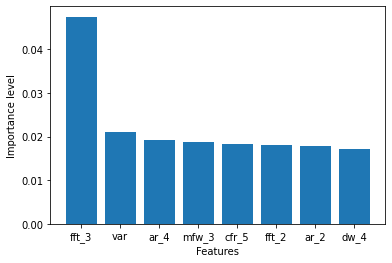

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,267.535629,270.981533,270.243834,76.791207,11.207306,0.483334,-0.435149,-0.637676,-0.096703,-1.065012,...,0.016873,0.040724,-0.047331,0.034527,-0.042788,0.048729,-0.072291,0.006842,-0.025811,-0.008343
1,277.949875,283.546637,283.543383,80.370321,11.621628,0.480582,-0.437337,-0.666380,-0.138188,-2.207264,...,0.011581,0.052652,-0.053865,0.034099,-0.034026,0.038144,-0.071427,0.011442,-0.027634,-0.009450
2,280.952321,289.729213,288.768479,81.676148,11.842770,0.479468,-0.434101,-0.641674,-0.075015,-0.855778,...,0.031430,0.033720,-0.041838,0.031072,-0.035728,0.040951,-0.067828,0.007170,-0.022649,-0.013308
3,266.093352,277.366979,279.066959,79.365536,11.515873,0.479998,-0.433339,-0.648197,-0.093792,-1.105237,...,0.018259,0.048839,-0.047719,0.029625,-0.035988,0.049478,-0.081219,0.019213,-0.029185,-0.014198
4,279.838160,290.933842,289.849559,81.839924,11.791220,0.479852,-0.432266,-0.660649,-0.107788,14.855103,...,0.015173,0.050778,-0.050448,0.030725,-0.035125,0.042994,-0.070263,0.010677,-0.027446,-0.011952


## Random Forest - L1SO

In [17]:
cvds = X_fsel.copy()
cvds["patient_id"] = patient_ids
cvds["label"] = y

patients = np.unique(cvds["patient_id"].values)
patients

array(['e0106', 'e0110', 'e0115', 'e0129', 'e0133', 'e0151', 'e0202',
       'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210',
       'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305',
       'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409',
       'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0515',
       'e0601', 'e0602', 'e0603', 'e0605', 'e0606', 'e0607', 'e0609',
       'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704',
       'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304'],
      dtype=object)

In [18]:
classes = np.unique(label_encoder.inverse_transform(y))

In [19]:
result_df = pd.DataFrame()
tot = len(patients)
for i, patient in enumerate(patients):
    start_time = time.time()

    # Train and Test split
    df1 = cvds.loc[cvds["patient_id"] != patient]
    df2 = cvds.loc[cvds["patient_id"] == patient]

    y_train = df1["label"].values
    x_train = df1.loc[:, ~df1.columns.isin(['patient_id', 'label'])]
    y_test = df2["label"].values
    x_test = df2.loc[:, ~df2.columns.isin(['patient_id', 'label'])]

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(patients), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
1 of 56 - 1.5467748641967773 s
Tot: Accuracy 0.8214285714285714 Precision 0.8533163265306122 Recall 0.8214285714285714 Specificity 0.17857142857142858 F1 0.7408963585434174
NSR: Accuracy 0.8214285714285714 Precision 0.8214285714285714 Recall 1.0 Specificity 0.0 F1 0.9019607843137255
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
2 of 56 - 1.5516605377197266 s
Tot: Accuracy 0.8090909090909091 Precision 0.8455371900826447 Recall 0.8090909090909091 Specificity 0.19090909090909092 F1 0.723709456372773
NSR: Accuracy 0.8090909090909091 Precision 0.8090909090909091 Recall 1.0 Specificity 0.0 F1 0.8944723618090452
ST+: Accuracy 0.8090909090909091 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.8090909090909091 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
3 of 56 - 1.5145492553710938 s
Tot: Accuracy 0.9209039548022598 Precision 0.9271601391681829 Recall 0.9209039548022598 Specificity 0.07909604519774012 F1 0.882984380192755
NSR: Accuracy 0.9209039548022598 Precision 0.9209039548022598 Recall 1.0 Specificity 0.0 F1 0.9588235294117646
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
4 of 56 - 1.528224229812622 s
Tot: Accuracy 0.8651685393258427 Precision 0.8833480621133695 Recall 0.8651685393258427 Specificity 0.1348314606741573 F1 0.8026262352781914
NSR: Accuracy 0.8651685393258427 Precision 0.8651685393258427 Recall 1.0 Specificity 0.0 F1 0.927710843373494
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
5 of 56 - 1.5262677669525146 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
6 of 56 - 1.574120044708252 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
7 of 56 - 1.567279577255249 s
Tot: Accuracy 0.7115384615384616 Precision 0.7947485207100592 Recall 0.7115384615384616 Specificity 0.28846153846153844 F1 0.5916162489196197
NSR: Accuracy 0.7115384615384616 Precision 0.7115384615384616 Recall 1.0 Specificity 0.0 F1 0.8314606741573033
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
8 of 56 - 1.4969751834869385 s
Tot: Accuracy 0.7735849056603774 Precision 0.7792579460554641 Recall 0.7735849056603774 Specificity 0.39979726772179597 F1 0.7175376758296321
NSR: Accuracy 0.7735849056603774 Precision 0.7718120805369127 Recall 0.9829059829059829 Specificity 0.19047619047619047 F1 0.8646616541353384
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8 Recall 0.19047619047619047 Specificity 0.9829059829059829 F1 0.3076923076923077
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
9 of 56 - 1.5291974544525146 s
Tot: Accuracy 0.9116022099447514 Precision 0.9901780233271946 Recall 0.9116022099447514 Specificity 0.9990123151949134 F1 0.9448935414041549
NSR: Accuracy 0.9116022099447514 Precision 1.0 Recall 0.9106145251396648 Specificity 1.0 F1 0.9532163742690057
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.1111111111111111 Recall 1.0 Specificity 0.9106145251396648 F1 0.19999999999999998
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
10 of 56 - 1.5135753154754639 s
Tot: Accuracy 0.6542553191489362 Precision 0.7737947034857402 Recall 0.6542553191489362 Specificity 0.34574468085106386 F1 0.5175138537319559
NSR: Accuracy 0.6542553191489362 Precision 0.6542553191489362 Recall 1.0 Specificity 0.0 F1 0.7909967845659164
ST+: Accuracy 0.6542553191489362 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6542553191489362 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
11 of 56 - 1.5282230377197266 s
Tot: Accuracy 0.7790697674418605 Precision 0.8284541723666211 Recall 0.7790697674418605 Specificity 0.2709302325581395 F1 0.6930247225950291
NSR: Accuracy 0.7790697674418605 Precision 0.7764705882352941 Recall 1.0 Specificity 0.05 F1 0.8741721854304636
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.05 Specificity 1.0 F1 0.09523809523809523
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
12 of 56 - 1.553612232208252 s
Tot: Accuracy 0.7522123893805309 Precision 0.8136110893570364 Recall 0.7522123893805309 Specificity 0.24778761061946902 F1 0.6458389201752033
NSR: Accuracy 0.7522123893805309 Precision 0.7522123893805309 Recall 1.0 Specificity 0.0 F1 0.8585858585858585
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
13 of 56 - 1.4891605377197266 s
Tot: Accuracy 0.8978102189781022 Precision 0.9082529703234056 Recall 0.8978102189781022 Specificity 0.10218978102189781 F1 0.8494665918023583
NSR: Accuracy 0.8978102189781022 Precision 0.8978102189781022 Recall 1.0 Specificity 0.0 F1 0.9461538461538462
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
14 of 56 - 1.5243160724639893 s
Tot: Accuracy 0.8102189781021898 Precision 0.8462358143747669 Recall 0.8102189781021898 Specificity 0.1897810218978102 F1 0.7252766658817988
NSR: Accuracy 0.8102189781021898 Precision 0.8102189781021898 Recall 1.0 Specificity 0.0 F1 0.8951612903225806
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
15 of 56 - 1.4579155445098877 s
Tot: Accuracy 0.8220338983050848 Precision 0.8537058316575696 Recall 0.8220338983050848 Specificity 0.17796610169491525 F1 0.7417422152148206
NSR: Accuracy 0.8220338983050848 Precision 0.8220338983050848 Recall 1.0 Specificity 0.0 F1 0.9023255813953489
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
16 of 56 - 1.520411491394043 s
Tot: Accuracy 0.9473684210526315 Precision 0.9501385041551246 Recall 0.9473684210526315 Specificity 0.05263157894736842 F1 0.9217638691322904
NSR: Accuracy 0.9473684210526315 Precision 0.9473684210526315 Recall 1.0 Specificity 0.0 F1 0.972972972972973
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
17 of 56 - 1.4940447807312012 s
Tot: Accuracy 0.6988636363636364 Precision 0.5762090380549684 Recall 0.6988636363636364 Specificity 0.2967442067736185 F1 0.5940235690235691
NSR: Accuracy 0.6988636363636364 Precision 0.7093023255813954 Recall 0.976 Specificity 0.0196078431372549 F1 0.8215488215488217
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.25 Recall 0.0196078431372549 Specificity 0.976 F1 0.03636363636363636
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
18 of 56 - 1.4413137435913086 s
Tot: Accuracy 0.9661538461538461 Precision 0.9672994082840236 Recall 0.9661538461538461 Specificity 0.033846153846153845 F1 0.9495220898037798
NSR: Accuracy 0.9661538461538461 Precision 0.9661538461538461 Recall 1.0 Specificity 0.0 F1 0.9827856025039123
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
19 of 56 - 1.4891602993011475 s
Tot: Accuracy 0.8561151079136691 Precision 0.8768179700843641 Recall 0.8561151079136691 Specificity 0.14388489208633093 F1 0.7897495956722993
NSR: Accuracy 0.8561151079136691 Precision 0.8561151079136691 Recall 1.0 Specificity 0.0 F1 0.9224806201550387
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
20 of 56 - 1.437408685684204 s
Tot: Accuracy 0.9847328244274809 Precision 0.9771869790295693 Recall 0.9847328244274809 Specificity 0.011406171711515221 F1 0.9809453904873753
NSR: Accuracy 0.9847328244274809 Precision 0.9885057471264368 Recall 0.9961389961389961 Specificity 0.0 F1 0.9923076923076923
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9961389961389961 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
21 of 56 - 1.5096685886383057 s
Tot: Accuracy 0.8108108108108109 Precision 0.8466033601168736 Recall 0.8108108108108109 Specificity 0.1891891891891892 F1 0.7260992335619201
NSR: Accuracy 0.8108108108108109 Precision 0.8108108108108109 Recall 1.0 Specificity 0.0 F1 0.8955223880597014
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
22 of 56 - 1.5233392715454102 s
Tot: Accuracy 0.6774193548387096 Precision 0.781477627471384 Recall 0.6774193548387096 Specificity 0.3225806451612903 F1 0.5471464019851118
NSR: Accuracy 0.6774193548387096 Precision 0.6774193548387096 Recall 1.0 Specificity 0.0 F1 0.8076923076923077
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
23 of 56 - 1.523339033126831 s
Tot: Accuracy 0.3310344827586207 Precision 0.7785493460166468 Recall 0.3310344827586207 Specificity 0.6689655172413793 F1 0.1646596390923709
NSR: Accuracy 0.3310344827586207 Precision 0.3310344827586207 Recall 1.0 Specificity 0.0 F1 0.49740932642487046
ST+: Accuracy 0.3310344827586207 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.3310344827586207 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#
#---------------------#
24 of 56 - 1.5389623641967773 s
Tot: Accuracy 0.8440366972477065 Precision 0.86836124905311 Recall 0.8440366972477065 Specificity 0.1559633027522936 F1 0.7726505089232736
NSR: Accuracy 0.8440366972477065 Precision 0.8440366972477065 Recall 1.0 Specificity 0.0 F1 0.9154228855721394
ST+: Accuracy 0.908256880733945 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.908256880733945 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
25 of 56 - 1.511622667312622 s
Tot: Accuracy 0.7085714285714285 Precision 0.7519047619047617 Recall 0.7085714285714285 Specificity 0.3901680672268908 F1 0.6201161440185831
NSR: Accuracy 0.7085714285714285 Precision 0.7023809523809523 Recall 0.9915966386554622 Specificity 0.10714285714285714 F1 0.8222996515679443
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8571428571428571 Recall 0.10714285714285714 Specificity 0.9915966386554622 F1 0.19047619047619047
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
26 of 56 - 1.5243182182312012 s
Tot: Accuracy 0.7304964539007093 Precision 0.8031286152608018 Recall 0.7304964539007093 Specificity 0.2695035460992908 F1 0.6167306127194513
NSR: Accuracy 0.7304964539007093 Precision 0.7304964539007093 Recall 1.0 Specificity 0.0 F1 0.8442622950819673
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
27 of 56 - 1.514552354812622 s
Tot: Accuracy 0.524822695035461 Precision 0.7663942187280467 Recall 0.524822695035461 Specificity 0.12219084316588084 F1 0.6203078574352525
NSR: Accuracy 0.524822695035461 Precision 0.8488372093023255 Recall 0.5748031496062992 Specificity 0.07142857142857142 F1 0.6854460093896713
ST+: Accuracy 0.9929078014184397 Precision 0.0 Recall 1.0 Specificity 0.9929078014184397 F1 0.0
ST-: Accuracy 0.9929078014184397 precision 0.018518518518518517 Recall 0.07142857142857142 Specificity 0.5826771653543307 F1 0.029411764705882353
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
28 of 56 - 1.511620283126831 s
Tot: Accuracy 0.04975124378109453 Precision 0.9527239424766714 Recall 0.04975124378109453 Specificity 0.9502487562189055 F1 0.00471575770436915
NSR: Accuracy 0.04975124378109453 Precision 0.04975124378109453 Recall 1.0 Specificity 0.0 F1 0.09478672985781991
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
29 of 56 - 1.541893482208252 s
Tot: Accuracy 0.1440677966101695 Precision 0.8766877334099397 Recall 0.1440677966101695 Specificity 0.8559322033898306 F1 0.036283741368487124
NSR: Accuracy 0.1440677966101695 Precision 0.1440677966101695 Recall 1.0 Specificity 0.0 F1 0.2518518518518518
ST+: Accuracy 0.1440677966101695 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.1440677966101695 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
30 of 56 - 1.4657256603240967 s
Tot: Accuracy 0.9230769230769231 Precision 0.9289940828402368 Recall 0.9230769230769231 Specificity 0.07692307692307693 F1 0.8861538461538462
NSR: Accuracy 0.9230769230769231 Precision 0.9230769230769231 Recall 1.0 Specificity 0.0 F1 0.9600000000000001
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
31 of 56 - 1.5282208919525146 s
Tot: Accuracy 0.90625 Precision 0.9151082677165354 Recall 0.90625 Specificity 0.17067307692307693 F1 0.8683958087367178
NSR: Accuracy 0.90625 Precision 0.905511811023622 Recall 1.0 Specificity 0.07692307692307693 F1 0.9504132231404958
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.07692307692307693 Specificity 1.0 F1 0.14285714285714288
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
32 of 56 - 1.4881844520568848 s
Tot: Accuracy 0.5978260869565217 Precision 0.75823656494734 Recall 0.5978260869565217 Specificity 0.6225169053557196 F1 0.5330420044215181
NSR: Accuracy 0.5978260869565217 Precision 0.546583850931677 Recall 0.9887640449438202 Specificity 0.23157894736842105 F1 0.7040000000000001
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9565217391304348 Recall 0.23157894736842105 Specificity 0.9887640449438202 F1 0.3728813559322034
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
33 of 56 - 1.4940452575683594 s
Tot: Accuracy 0.8402777777777778 Precision 0.8657889660493827 Recall 0.8402777777777778 Specificity 0.1597222222222222 F1 0.7673480083857442
NSR: Accuracy 0.8402777777777778 Precision 0.8402777777777778 Recall 1.0 Specificity 0.0 F1 0.9132075471698113
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
34 of 56 - 1.4579148292541504 s
Tot: Accuracy 0.726775956284153 Precision 0.93885112621618 Recall 0.726775956284153 Specificity 0.9033410027801744 F1 0.795546633954128
NSR: Accuracy 0.726775956284153 Precision 0.991869918699187 Recall 0.7134502923976608 Specificity 0.9166666666666666 F1 0.8299319727891156
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.18333333333333332 Recall 0.9166666666666666 Specificity 0.7134502923976608 F1 0.3055555555555556
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
35 of 56 - 1.5272459983825684 s
Tot: Accuracy 0.9532163742690059 Precision 0.9554050819055436 Recall 0.9532163742690059 Specificity 0.04678362573099415 F1 0.9303848443463949
NSR: Accuracy 0.9532163742690059 Precision 0.9532163742690059 Recall 1.0 Specificity 0.0 F1 0.9760479041916168
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
36 of 56 - 1.4793963432312012 s
Tot: Accuracy 0.9714285714285714 Precision 1.0 Recall 0.9714285714285714 Specificity 0.0 F1 0.9855072463768116
NSR: Accuracy 0.9714285714285714 Precision 1.0 Recall 0.9714285714285714 Specificity 0.0 F1 0.9855072463768115
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9714285714285714 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
37 of 56 - 1.4676792621612549 s
Tot: Accuracy 0.8857142857142857 Precision 0.8621645021645021 Recall 0.8857142857142857 Specificity 0.29829137599838235 F1 0.8708074534161491
NSR: Accuracy 0.8857142857142857 Precision 0.9151515151515152 Recall 0.9617834394904459 Specificity 0.2222222222222222 F1 0.9378881987577641
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.4 Recall 0.2222222222222222 Specificity 0.9617834394904459 F1 0.2857142857142857
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
38 of 56 - 1.5062739849090576 s
Tot: Accuracy 0.048 Precision 0.9543039999999999 Recall 0.048 Specificity 0.952 F1 0.0043969465648854966
NSR: Accuracy 0.048 Precision 0.048 Recall 1.0 Specificity 0.0 F1 0.0916030534351145
ST+: Accuracy 0.048 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.048 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
39 of 56 - 1.5106465816497803 s
Tot: Accuracy 0.7595628415300546 Precision 0.8173728687031561 Recall 0.7595628415300546 Specificity 0.24043715846994534 F1 0.6557716457930286
NSR: Accuracy 0.7595628415300546 Precision 0.7595628415300546 Recall 1.0 Specificity 0.0 F1 0.8633540372670807
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
40 of 56 - 1.5282211303710938 s
Tot: Accuracy 0.8092105263157895 Precision 0.6645172533983966 Recall 0.8092105263157895 Specificity 0.18272495755517826 F1 0.7297607655502393
NSR: Accuracy 0.8092105263157895 Precision 0.8145695364238411 Recall 0.9919354838709677 Specificity 0.0 F1 0.8945454545454545
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9919354838709677 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
41 of 56 - 1.527245044708252 s
Tot: Accuracy 0.3765432098765432 Precision 0.7701003086419753 Recall 0.3765432098765432 Specificity 0.6428742658516121 F1 0.2204553324796856
NSR: Accuracy 0.3765432098765432 Precision 0.36875 Recall 1.0 Specificity 0.019417475728155338 F1 0.5388127853881279
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.019417475728155338 Specificity 1.0 F1 0.03809523809523809
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
42 of 56 - 1.4872074127197266 s
Tot: Accuracy 0.9319727891156463 Precision 0.9128966271823414 Recall 0.9319727891156463 Specificity 0.17144447707140412 F1 0.9211173831234623
NSR: Accuracy 0.9319727891156463 Precision 0.951048951048951 Recall 0.9784172661870504 Specificity 0.125 F1 0.9645390070921986
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.25 Recall 0.125 Specificity 0.9784172661870504 F1 0.16666666666666666
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
43 of 56 - 1.4857759475708008 s
Tot: Accuracy 0.8571428571428571 Precision 0.8775510204081632 Recall 0.8571428571428571 Specificity 0.14285714285714285 F1 0.7912087912087911
NSR: Accuracy 0.8571428571428571 Precision 0.8571428571428571 Recall 1.0 Specificity 0.0 F1 0.923076923076923
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
44 of 56 - 1.520059585571289 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
45 of 56 - 1.551321029663086 s
Tot: Accuracy 0.6 Precision 0.7741258741258742 Recall 0.6 Specificity 0.4406926406926407 F1 0.47441860465116276
NSR: Accuracy 0.6363636363636364 Precision 0.6346153846153846 Recall 0.9705882352941176 Specificity 0.09523809523809523 F1 0.7674418604651162
ST+: Accuracy 0.6181818181818182 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6181818181818182 precision 0.0 Recall 1.0 Specificity 0.9454545454545454 F1 0.0
#---------------------#
#---------------------#
46 of 56 - 1.5440044403076172 s
Tot: Accuracy 0.753968253968254 Precision 0.8144998740236835 Recall 0.753968253968254 Specificity 0.24603174603174602 F1 0.6482080011491776
NSR: Accuracy 0.753968253968254 Precision 0.753968253968254 Recall 1.0 Specificity 0.0 F1 0.8597285067873303
ST+: Accuracy 0.9841269841269841 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.9841269841269841 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
47 of 56 - 1.5601806640625 s
Tot: Accuracy 0.398876404494382 Precision 0.3995117710005351 Recall 0.398876404494382 Specificity 0.5570270527789383 F1 0.26906494069856307
NSR: Accuracy 0.398876404494382 Precision 0.39880952380952384 Recall 0.9178082191780822 Specificity 0.0380952380952381 F1 0.5560165975103735
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.4 Recall 0.0380952380952381 Specificity 0.9178082191780822 F1 0.06956521739130436
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
48 of 56 - 1.5137007236480713 s
Tot: Accuracy 0.9824561403508771 Precision 0.9827639273622654 Recall 0.9824561403508771 Specificity 0.017543859649122806 F1 0.9737618382238783
NSR: Accuracy 0.9824561403508771 Precision 0.9824561403508771 Recall 1.0 Specificity 0.0 F1 0.9911504424778761
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
49 of 56 - 1.496068000793457 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
50 of 56 - 1.5058844089508057 s
Tot: Accuracy 0.9668874172185431 Precision 1.0 Recall 0.9668874172185431 Specificity 0.0 F1 0.9831649831649832
NSR: Accuracy 0.9668874172185431 Precision 1.0 Recall 0.9668874172185431 Specificity 0.0 F1 0.9831649831649832
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9668874172185431 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
51 of 56 - 1.5502433776855469 s
Tot: Accuracy 0.11864406779661017 Precision 0.8955932203389831 Recall 0.11864406779661017 Specificity 0.8828770099956541 F1 0.025423728813559317
NSR: Accuracy 0.12994350282485875 Precision 0.12 Recall 1.0 Specificity 0.01282051282051282 F1 0.21428571428571425
ST+: Accuracy 0.11864406779661017 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.11864406779661017 precision 0.0 Recall 1.0 Specificity 0.9887005649717514 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
52 of 56 - 1.481349229812622 s
Tot: Accuracy 0.9349593495934959 Precision 1.0 Recall 0.9349593495934959 Specificity 0.0 F1 0.9663865546218486
NSR: Accuracy 0.9349593495934959 Precision 1.0 Recall 0.9349593495934959 Specificity 0.0 F1 0.9663865546218486
ST+: Accuracy 0.943089430894309 Precision 0.0 Recall 1.0 Specificity 0.943089430894309 F1 0.0
ST-: Accuracy 0.943089430894309 precision 0.0 Recall 1.0 Specificity 0.991869918699187 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
53 of 56 - 1.408113718032837 s
Tot: Accuracy 0.7267080745341615 Precision 0.8023360287511231 Recall 0.7267080745341615 Specificity 0.3167701863354037 F1 0.6233924226624955
NSR: Accuracy 0.7267080745341615 Precision 0.7232704402515723 Recall 1.0 Specificity 0.043478260869565216 F1 0.8394160583941604
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.043478260869565216 Specificity 1.0 F1 0.08333333333333333
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
54 of 56 - 1.3661236763000488 s
Tot: Accuracy 0.8686131386861314 Precision 0.886002576212967 Recall 0.8686131386861314 Specificity 0.18401844026123704 F1 0.8141444910627048
NSR: Accuracy 0.8686131386861314 Precision 0.8676470588235294 Recall 1.0 Specificity 0.05263157894736842 F1 0.9291338582677166
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.05263157894736842 Specificity 1.0 F1 0.1
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
55 of 56 - 1.4012789726257324 s
Tot: Accuracy 0.9015151515151515 Precision 0.9112144168962351 Recall 0.9015151515151515 Specificity 0.09848484848484848 F1 0.854823131715562
NSR: Accuracy 0.9015151515151515 Precision 0.9015151515151515 Recall 1.0 Specificity 0.0 F1 0.9482071713147411
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#
#---------------------#
56 of 56 - 1.3915107250213623 s
Tot: Accuracy 0.7741935483870968 Precision 0.8251821019771071 Recall 0.7741935483870968 Specificity 0.22580645161290322 F1 0.6756598240469208
NSR: Accuracy 0.7741935483870968 Precision 0.7741935483870968 Recall 1.0 Specificity 0.0 F1 0.8727272727272727
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.821429,0.853316,0.821429,0.178571,0.740896,0.821429,0.821429,1.000000,0.000000,0.901961,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
1,0.809091,0.845537,0.809091,0.190909,0.723709,0.809091,0.809091,1.000000,0.000000,0.894472,0.809091,1.0,0.0,1.0,0.0,0.809091,1.000000,1.000000,1.000000,1.000000
2,0.920904,0.927160,0.920904,0.079096,0.882984,0.920904,0.920904,1.000000,0.000000,0.958824,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
3,0.865169,0.883348,0.865169,0.134831,0.802626,0.865169,0.865169,1.000000,0.000000,0.927711,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
4,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
5,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
6,0.711538,0.794749,0.711538,0.288462,0.591616,0.711538,0.711538,1.000000,0.000000,0.831461,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000
7,0.773585,0.779258,0.773585,0.399797,0.717538,0.773585,0.771812,0.982906,0.190476,0.864662,1.000000,1.0,1.0,1.0,1.0,1.000000,0.800000,0.190476,0.982906,0.307692
8,0.911602,0.990178,0.911602,0.999012,0.944894,0.911602,1.000000,0.910615,1.000000,0.953216,1.000000,1.0,1.0,1.0,1.0,1.000000,0.111111,1.000000,0.910615,0.200000
9,0.654255,0.773795,0.654255,0.345745,0.517514,0.654255,0.654255,1.000000,0.000000,0.790997,0.654255,1.0,0.0,1.0,0.0,0.654255,1.000000,1.000000,1.000000,1.000000


In [21]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_64beats_l1so.csv')

######## Total ########
Accuracy 0.7574461190829764
Precision 0.8639929286510979
Recall 0.7574461190829764
Specificity 0.2794316995136664
F1 0.6998247590748589
######## NSR ########
Accuracy 0.7582972453578316
Precision 0.7723296824487317
Recall 0.9790728859294493
Specificity 0.05844156316186063
F1 0.831554951717108
######## ST+ ########
Accuracy 0.9205652766207276
Precision 0.9642857142857143
Recall 0.8392857142857143
Specificity 0.9988570934341563
F1 0.8035714285714286
######## ST- ########
Accuracy 0.9205652766207276
Precision 0.7719040635577903
Recall 0.30651194516081404
Specificity 0.9795791620006261
F1 0.2039973355361043
